- HOT는 업데이트된 행이 이전 행을 저장하는 동일한 테이블 페이지에 저장될 때 인덱스와 테이블의 페이지를 효과적으로 사용하기 위해 버전 8.3에서 구현.
- HOT은 또한 VACUUM 처리의 필요성을 줄여줌.

- HOT에 대한 자세한 내용은 소스코드 디렉터리의 README.HOT 파일에 설명되어 있으므로, HOT에 대한 간략한 소개만 제공

- 먼저 HOT가 해결하는 문제를 명확히 하기 위해 HOT 없이 행을 업데이트하는 방법을 설명, 그리고 HOT의 작동 방식을 설명

# **Update a Row Without HOT**


- 테이블 'tbl'에 'id'와 'data'라는 두 개의 열이 있다고 가정
- 'id'는 'tbl'의 기본 키.



```
testdb=# \d tbl
                Table "public.tbl"
 Column |  Type   | Collation | Nullable | Default
--------+---------+-----------+----------+---------
 id     | integer |           | not null |
 data   | text    |           |          |
Indexes:
    "tbl_pkey" PRIMARY KEY, btree (id)    
```

- 테이블 'tbl'에는 1000개의 튜플이 있음.
- ID가 1000인 마지막 튜플은 테이블의 5번째 페이지에 저장.
- 마지막 튜플은 키가 1000이고 tid가 '(5, 1)'인 해당 인덱스 튜플이 가리킴

**Update a row without HOT**

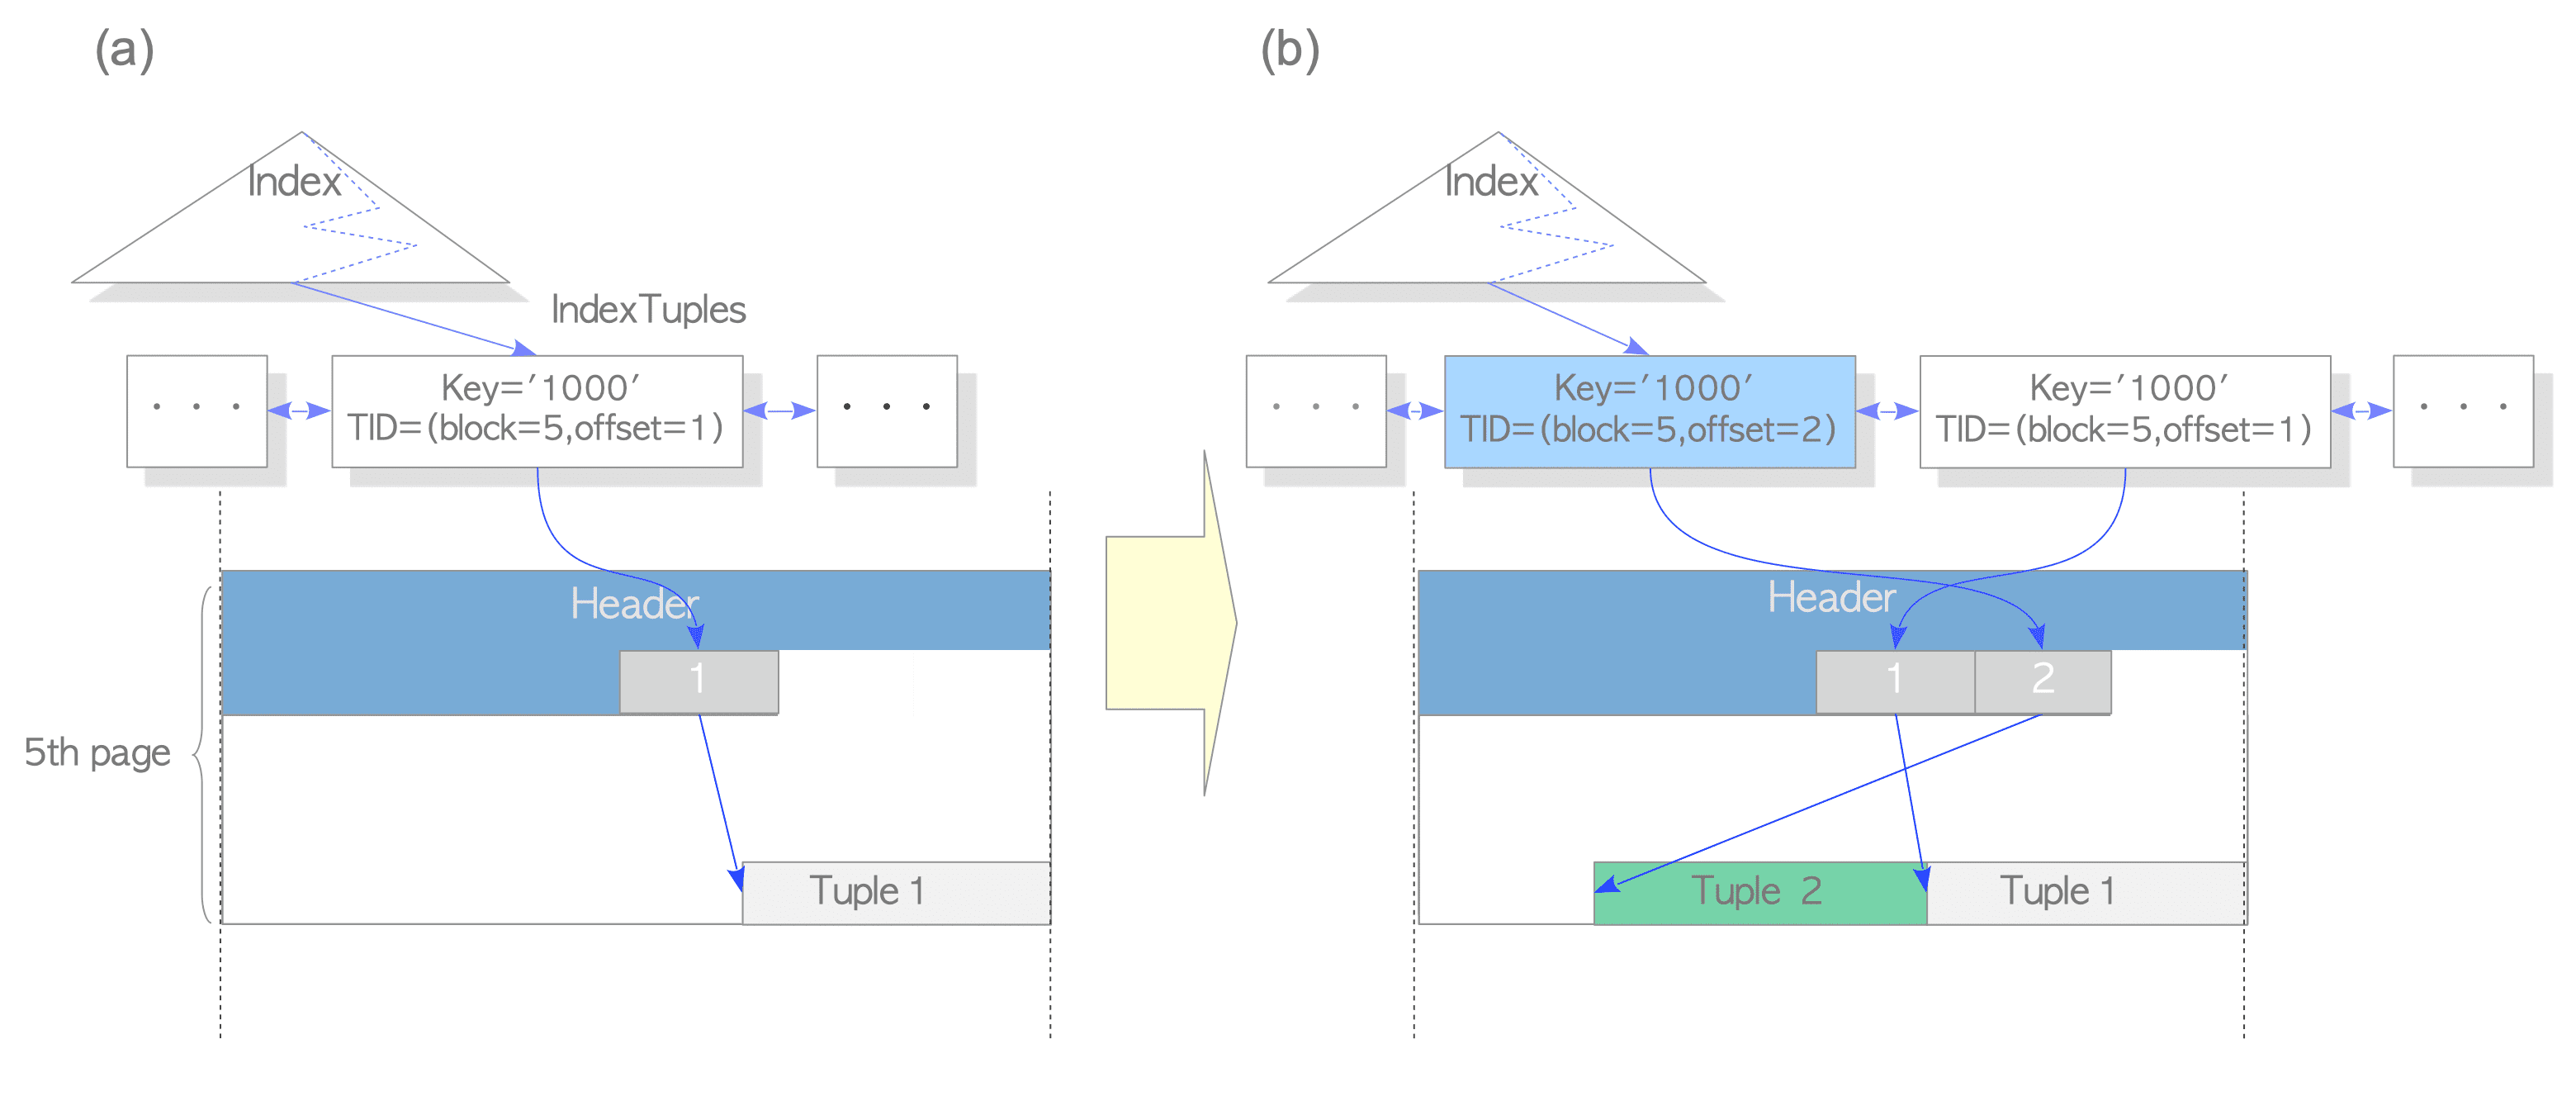

- HOT 없이 마지막 튜플이 어떻게 업데이트되는지 고려.



```
testdb=# UPDATE tbl SET data = 'B' WHERE id = 1000;
```

- 이 경우 PostgreSQL은 새 테이블 튜플뿐만 아니라 새 인덱스 튜플도 인덱스 페이지에 삽입

- 인덱스 튜플을 삽입하면 인덱스 페이지 공간이 소모되고 인덱스 튜플을 삽입하고 비우는 비용이 모두 높음.
  - HOT는 이러한 문제의 영향을 줄임.

# **How HOT Performs**

- 행이 HOT로 업데이트될 때, 업데이트된 행이 이전 행을 저장하는 동일한 테이블 페이지에 저장될 경우 PostgreSQL은 해당 인덱스 튜플을 삽입하지 않고 HEAP_HOT_UPDATED 비트와 HEAP_ONLY_TUPLE 비트를 이전 행의 t_informask2 필드로 설정.
  - 튜플과 새 튜플

**Update a row with HOT**

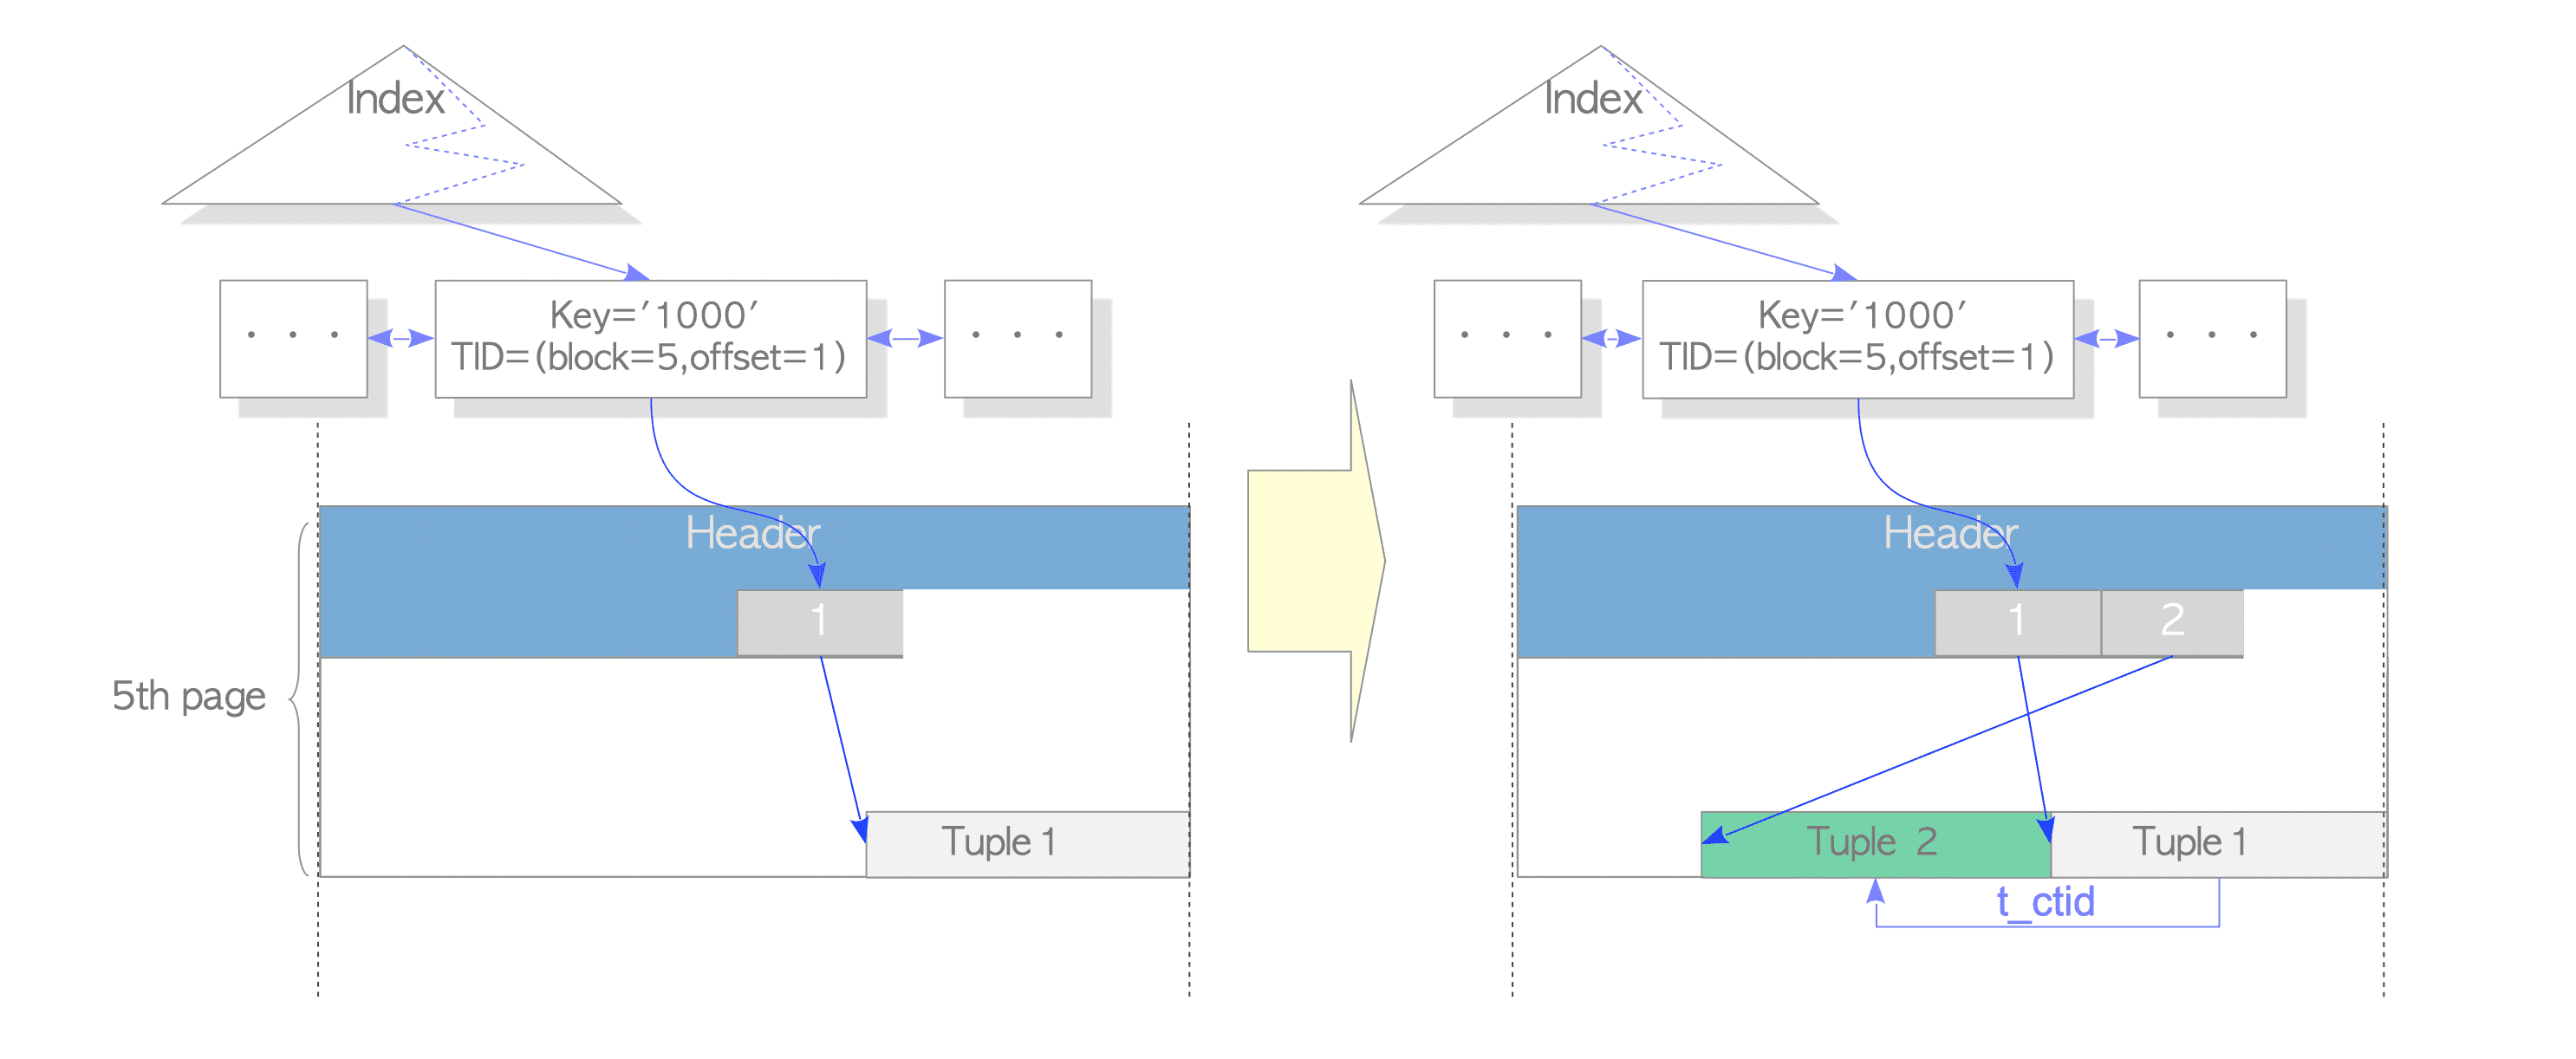

- 예를 들어, 이 경우 Tuple_1과 Tuple_2는 각각 HEAP_HOT_UPDATED 비트와 HEAP_ONLY_TUPLE 비트로 설정 됨.

- 또한 HEAP_HOT_UPDATED와 HEAP_ONLY_TUPLE 비트는 pruning과 관계없이 사용되며 , 아래에서 설명하는 조각 모음 과정이 실행 됨

**HEAP_HOT_UPDATED and HEAP_ONLY_TUPLE bits**

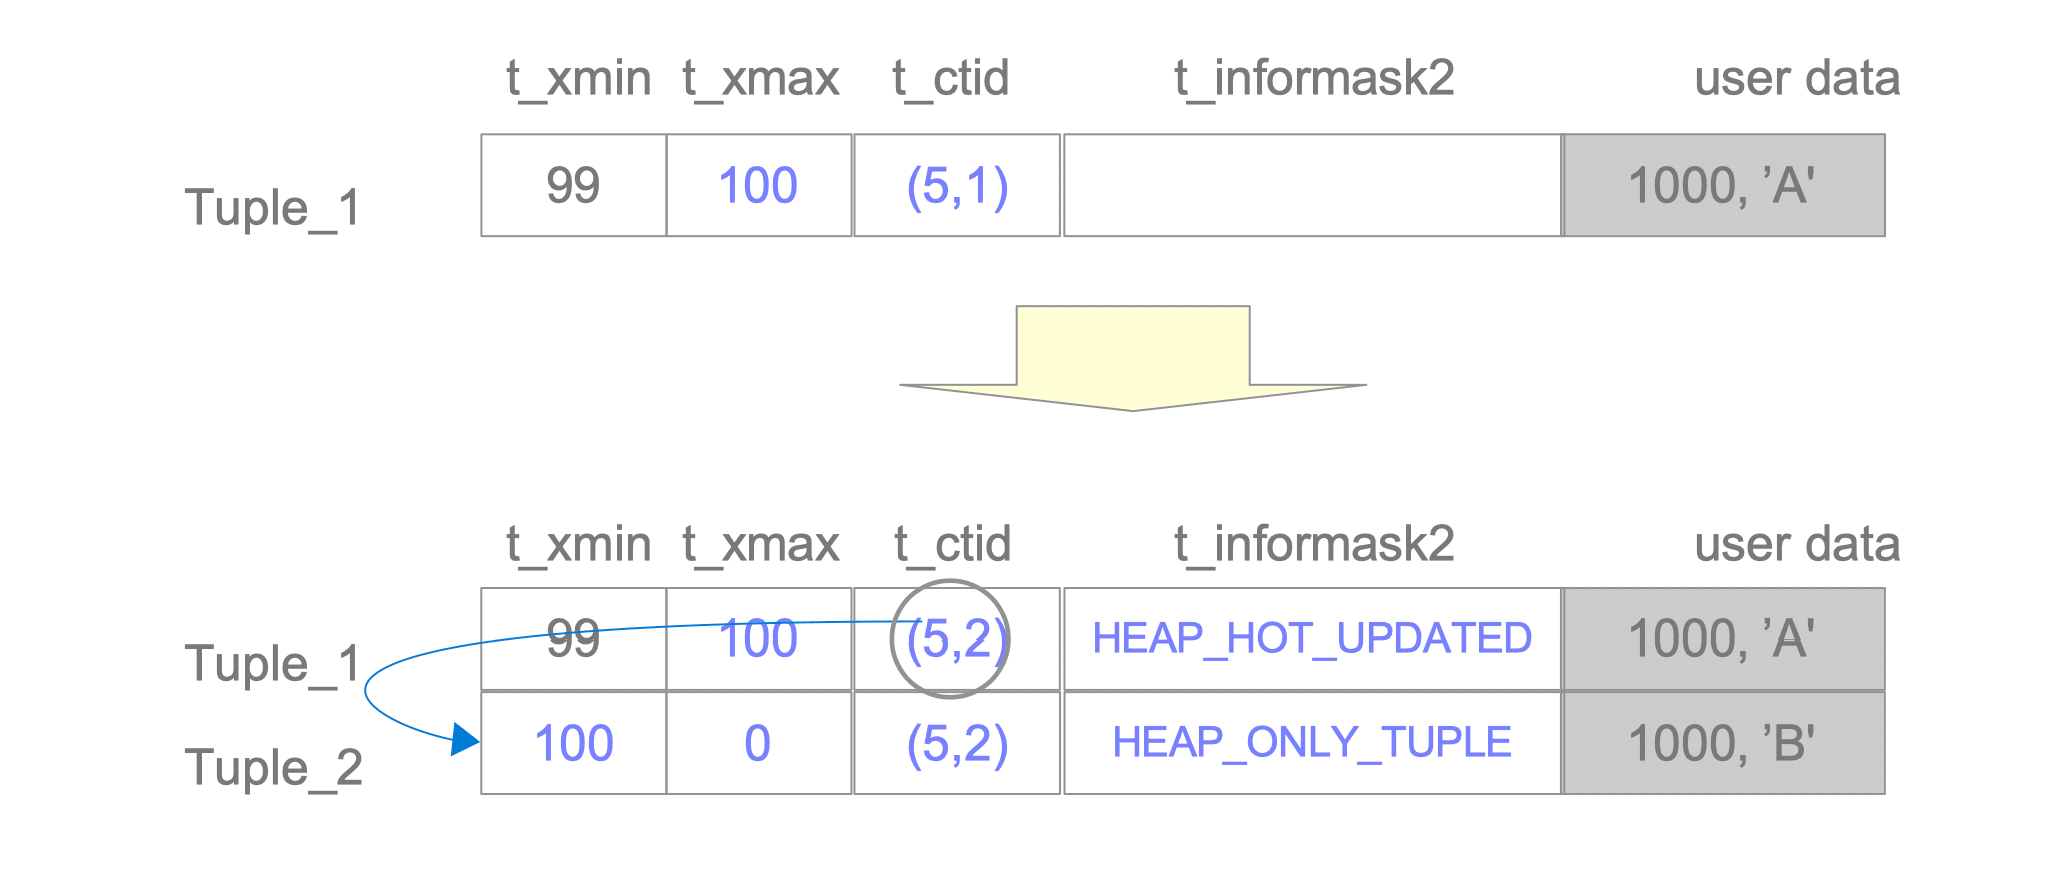

- 다음에서는 PostgreSQL이 HOT로 튜플을 업데이트한 후 즉시 인덱스 스캔을 사용하여 업데이트된 튜플에 액세스하는 방법에 대해 설명

**Pruning of the line pointers**

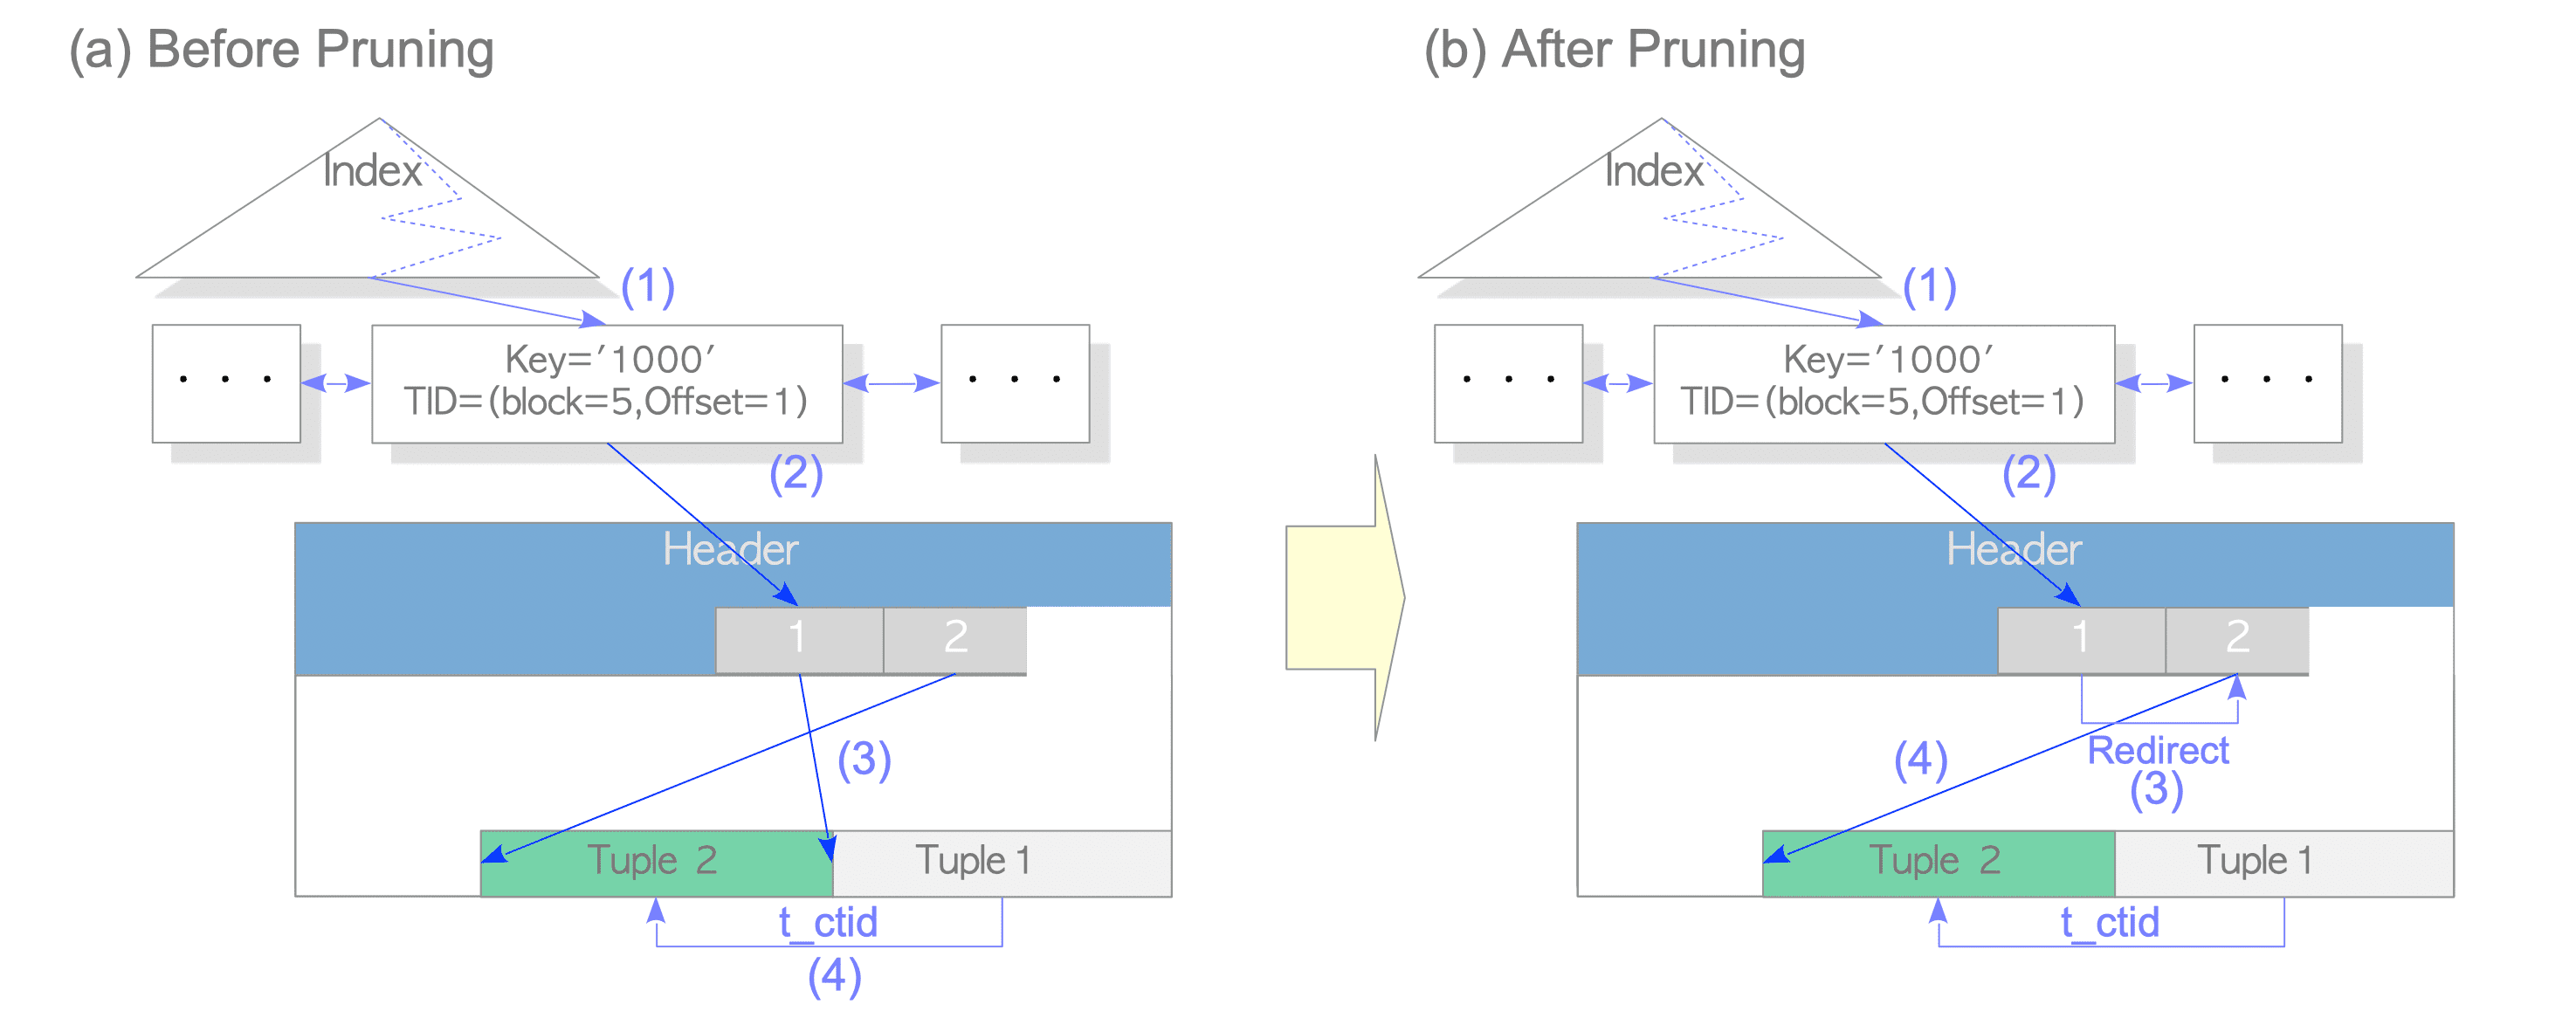

1. 대상 튜플을 가리키는 인덱스 튜플을 찾음.
2. 인덱스 튜플이 가리키는 라인 포인터 [1]에 접근.
3. Tuple_1을 읽음.
4. Tuple_1의 t_ctid를 통해 Tuple_2를 읽음.

- 이 경우 PostgreSQL은 Tuple_1과 Tuple_2라는 두 개의 튜플을 읽고 동시성 제어 메커니즘을 사용하여 어느 것이 표시되는지 결정.

- 그러나 테이블 페이지의 데드 튜플이 제거되면 문제가 발생.
  - 예를 들어 그림에서 Tuple_1이 데드 튜플이므로 제거되면 Tuple_2는 인덱스에서 접근할 수 없음.

- 이 문제를 해결하기 위해 PostgreSQL은 적절한 시점에 이전 튜플을 가리키는 라인 포인터를 새 튜플을 가리키는 라인 포인터로 리디렉션 함.
- PostgreSQL에서는 이러한 처리를 정리[pruning] 라고 함.
  - 그림은PostgreSQL이 정리 후 업데이트된 튜플에 액세스하는 방법을 보여줌.

1. 인덱스 튜플을 찾음.
2. 인덱스 튜플이 가리키는 라인 포인터 [1]에 접근.
3. 리디렉션된 라인 포인터를 통해 Tuple_2를 가리키는 라인 포인터 [2]에 액세스.
4. 라인 포인터 [2]가 가리키는 Tuple_2를 읽어옴.

- 가능한 경우 SELECT, UPDATE, INSERT, DELETE 등의 SQL 명령이 실행될 때 정리 처리가 실행됨.
- 정확한 실행 시점은 매우 복잡하기 때문에 이 장에서는 설명하지 않음.
  - 자세한 내용은 README.HOT 파일에 설명되어 있음.

- PostgreSQL은 가능한 경우 정리 프로세스에서와 같이 적절한 시간에 데드 튜플을 제거.
- PostgreSQL 문서에서는 이 처리를 조각 모음 이라고 함.
  - 그림 HOT에 의한 조각 모음을 보여줌.



**Defragmentation of the dead tuples**

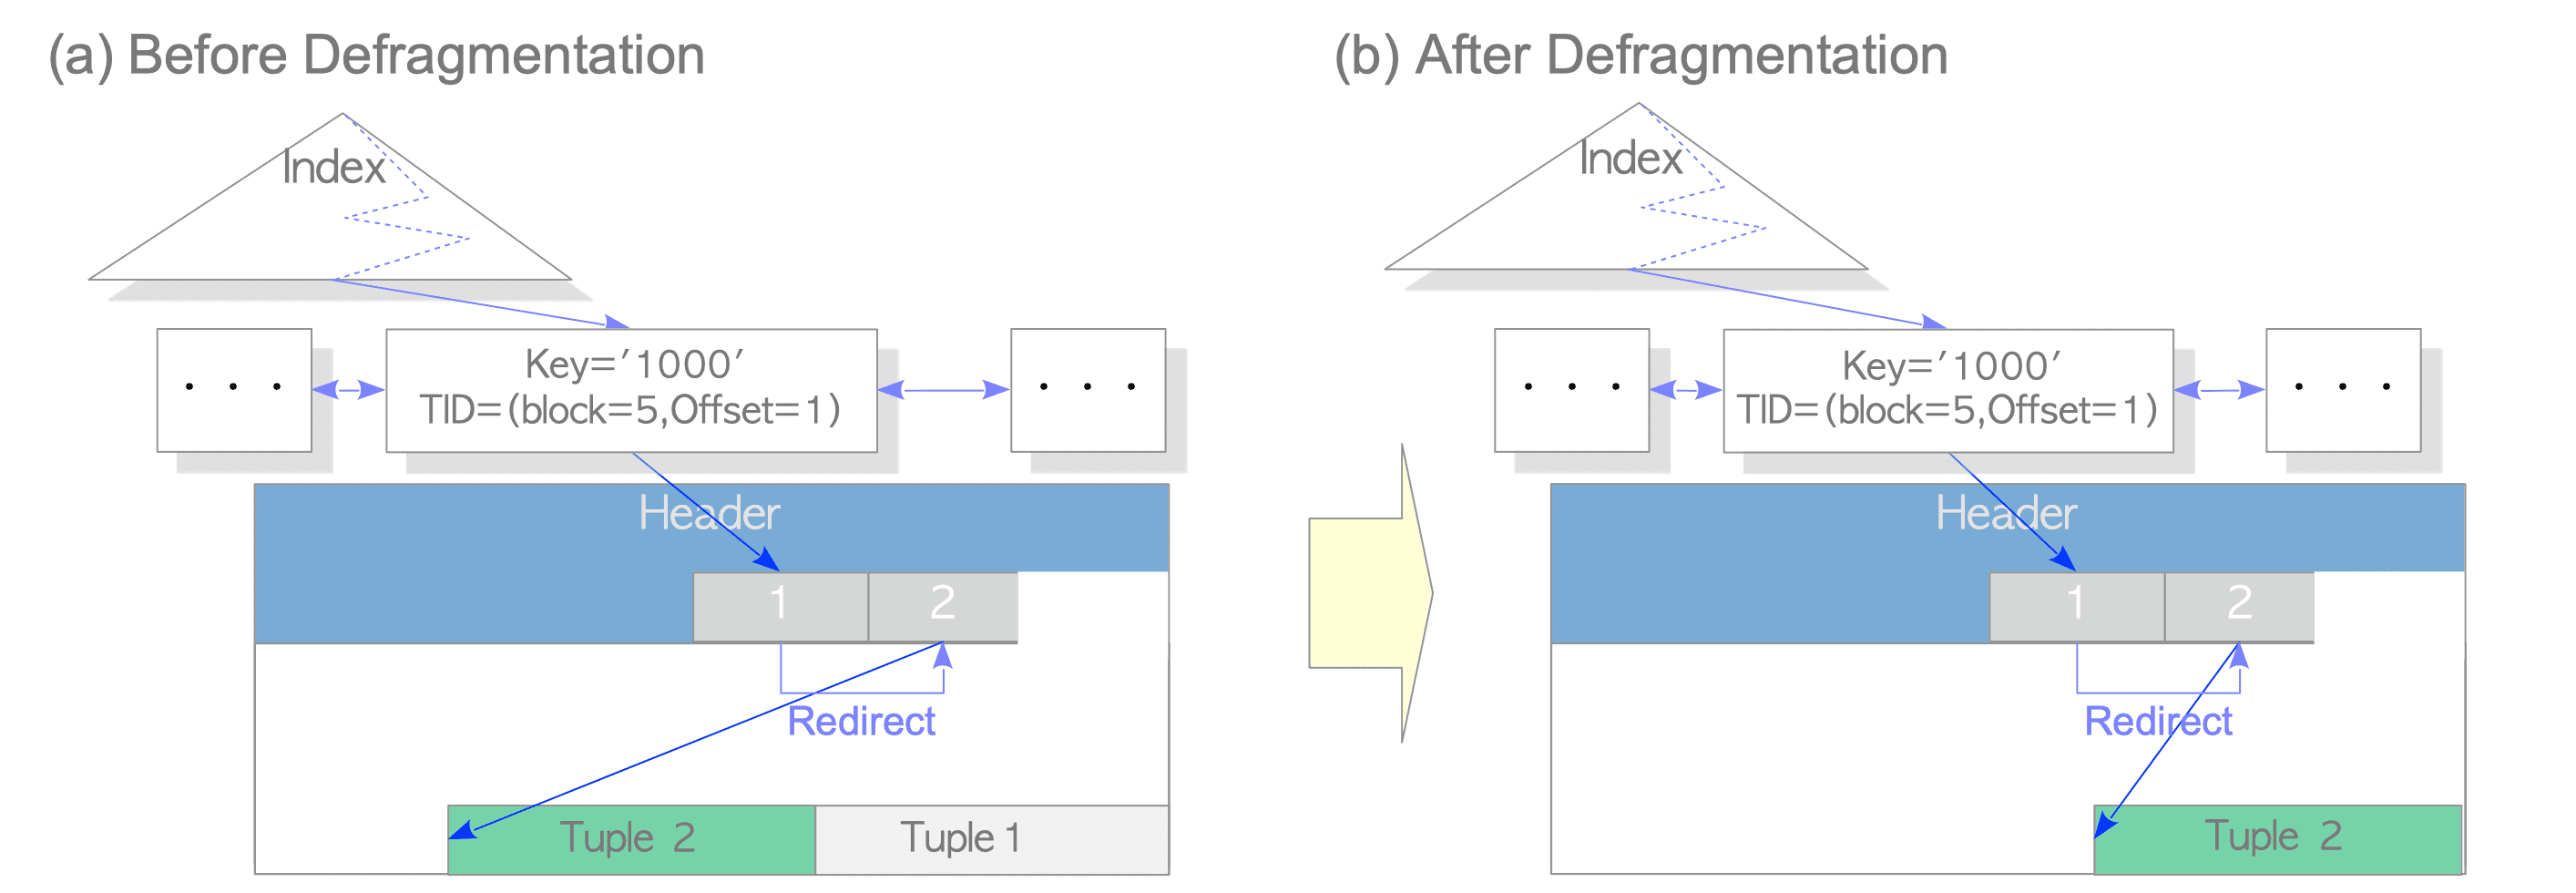

- 조각 모음에는 인덱스 튜플 제거가 포함되지 않으므로 조각 모음 비용은 일반 VACUUM 처리 비용보다 적음.

- 따라서 HOT를 사용하면 인덱스와 페이지 테이블의 소비가 줄어듬.
  - 이는 또한 VACUUM 처리가 처리해야 하는 튜플의 수도 줄임.
  - 따라서 HOT는 결국 업데이트를 통해 인덱스 튜플의 삽입 횟수를 줄이고 VACUUM 처리의 필요성을 줄여주기 때문에 성능에 긍정적인 영향을 미침.

**The Cases in which HOT is not available**


- 업데이트된 튜플이 이전 튜플을 저장하는 페이지와 다른 페이지에 저장되는 경우 해당 튜플을 가리키는 인덱스 튜플도 인덱스 페이지에 삽입되어야 힘.

- 인덱스 튜플의 키 값이 업데이트되면 인덱스 페이지에 새 인덱스 튜플을 삽입해야 함.

**The Cases in which HOT is not available**

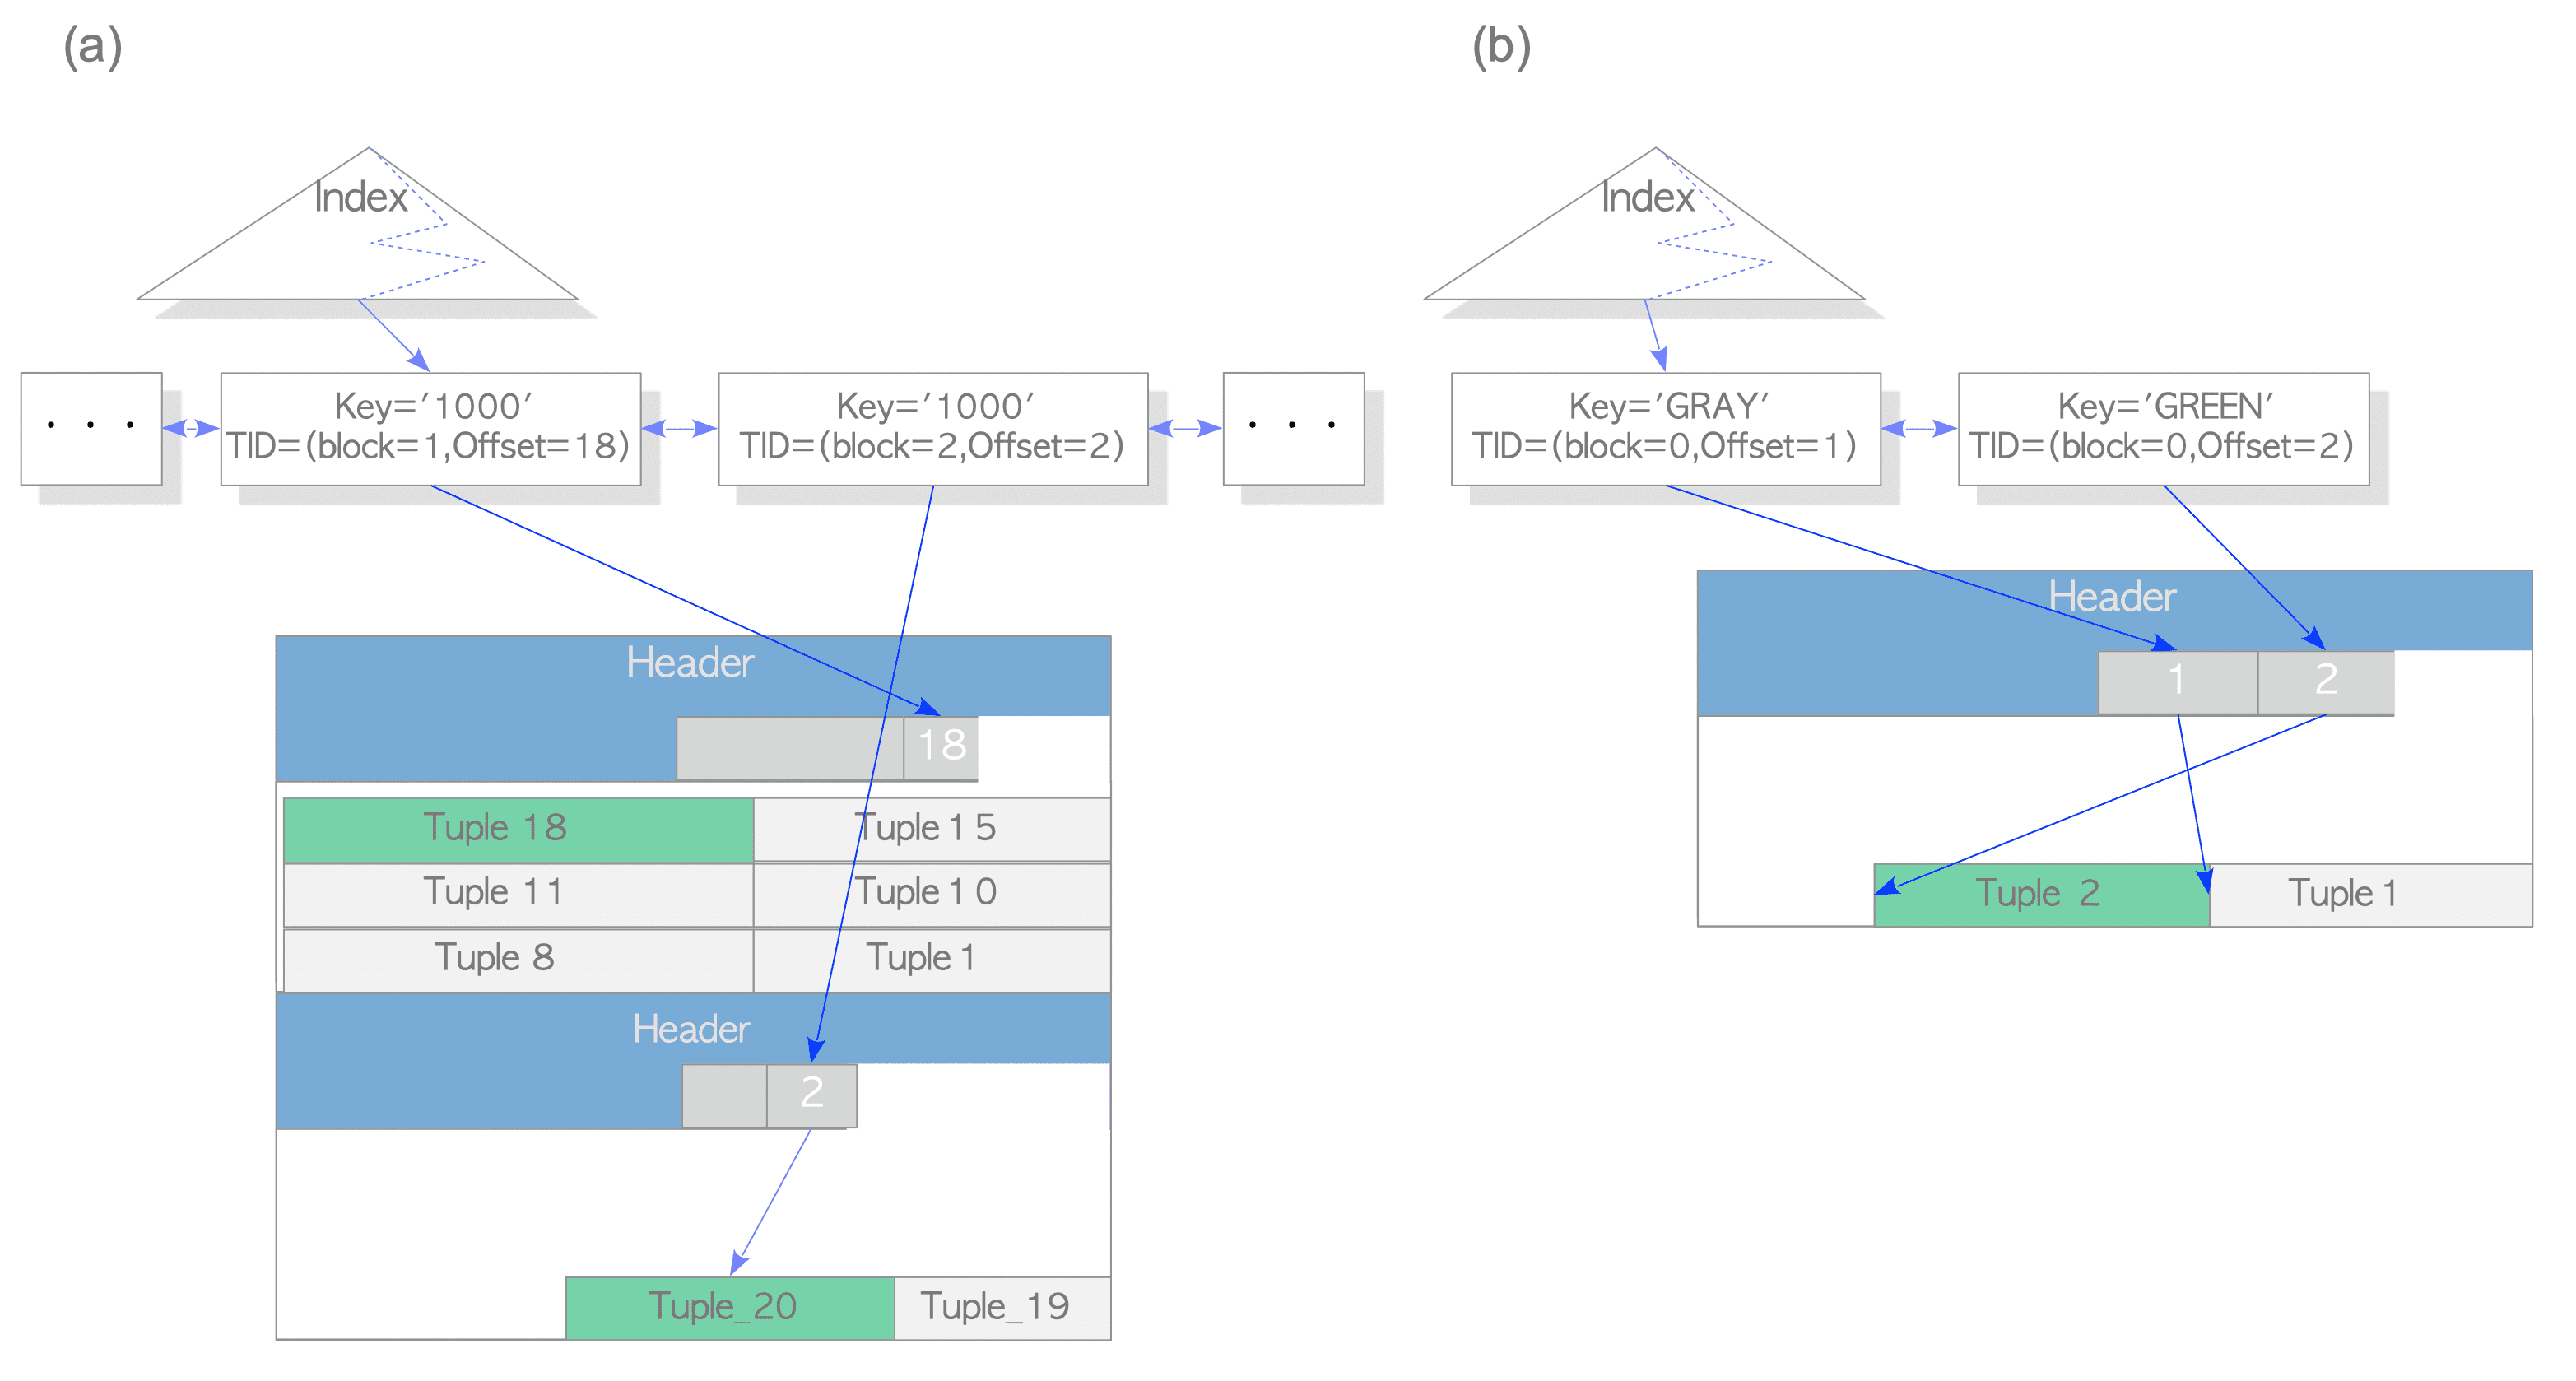